# Практический кейс
## «Прогнозирование размеров сварного шва при электронно-лучевой сварке тонкостенных конструкций аэрокосмического назначения»

В качестве исходных данных были взяты результаты экспериментальных
исследований, проводимых в целях улучшения технологического процесса
электронно-лучевой сварки изделия, сборка которого состоит из элементов,
состоящих из разнородного материала.
Установка электронно-лучевой сварки, на которой проводились
исследования, предназначена для сварки электронным лучом в глубоком вакууме
деталей сборочных единиц из нержавеющих сталей, титановых, алюминиевых
и специальных сплавов.
Существующая установка электронно-лучевой сварки обеспечивает
повторяемость режимов в рамках возможностей реализованной системы
управления. Работы по сварке выполнялись на образцах-имитаторах,
соответствующих технологическому изделию.
Для уменьшения вложения энергии при сварке:
1. Снижалась величина сварочного тока (IW);
2. Увеличивался ток фокусировки электронного пучка (IF);
3. Увеличивалась скорость сварки (VW);
4. Менялось расстояние от поверхности образцов до электронно-оптической
системы (FP).

По совокупности параметров технологических режимов обеспечивались
минимально возможные размеры сварных швов: глубина шва (Depth) и ширина
шва (Width).

В процессе выполнения работ была произведена электронно-лучевая сварка
18-ти единиц образцов. Результаты металлографического контроля
по размерам сварного шва для каждого образца проводились в 4-х поперечных
сечениях сварного шва. Ускоряющее напряжение было постоянным в диапазоне
19,8 – 20 кВ. Набор полученных данных собраны в составе режимов сварки,
размеров сварочных швов в поперечных сечениях всех образцов. Статистические
показатели набора обучающих данных указаны в табл. 1.

<img src="Task\Table1.png" alt="drawing" width="600"/>

## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Input

import pickle

## Загрузка датасета

In [2]:
raw_df = pd.read_csv("Dataset_case_1/ebw_data.csv")
raw_df.head()

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


## Разведочный анализ

**Посмотрим общий состав и тип данных**

In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


Пропусков нет. Все параметры числовые. 
Обращает внимание малый размер выборки - всего 72 записи.

**Посмотрим описательную статистику**

In [4]:
raw_df.describe().T

,count,mean,std,min,25%,50%,75%,max
IW,72.0,45.666667,1.678363,43.00,44.00,45.50,47.00,49.00
IF,72.0,141.333333,5.145763,131.00,139.00,141.00,146.00,150.00
VW,72.0,8.638889,2.061078,4.50,8.00,9.00,10.00,12.00
FP,72.0,78.333333,21.493530,50.00,60.00,80.00,80.00,125.00
Depth,72.0,1.195556,0.225081,0.80,1.08,1.20,1.29,1.76
Width,72.0,1.970417,0.279040,1.68,1.76,1.84,2.05,2.60


Некоторые параметры имеют значительную разницу в абсолютных значениях: IF - 141.33, FP - 78.33, VW - 8.64 и так далее.

Необходима нормализация при построении моделей.

**Просмотрим совместное распределение нескольких пар столбцов из обучающего набора.**

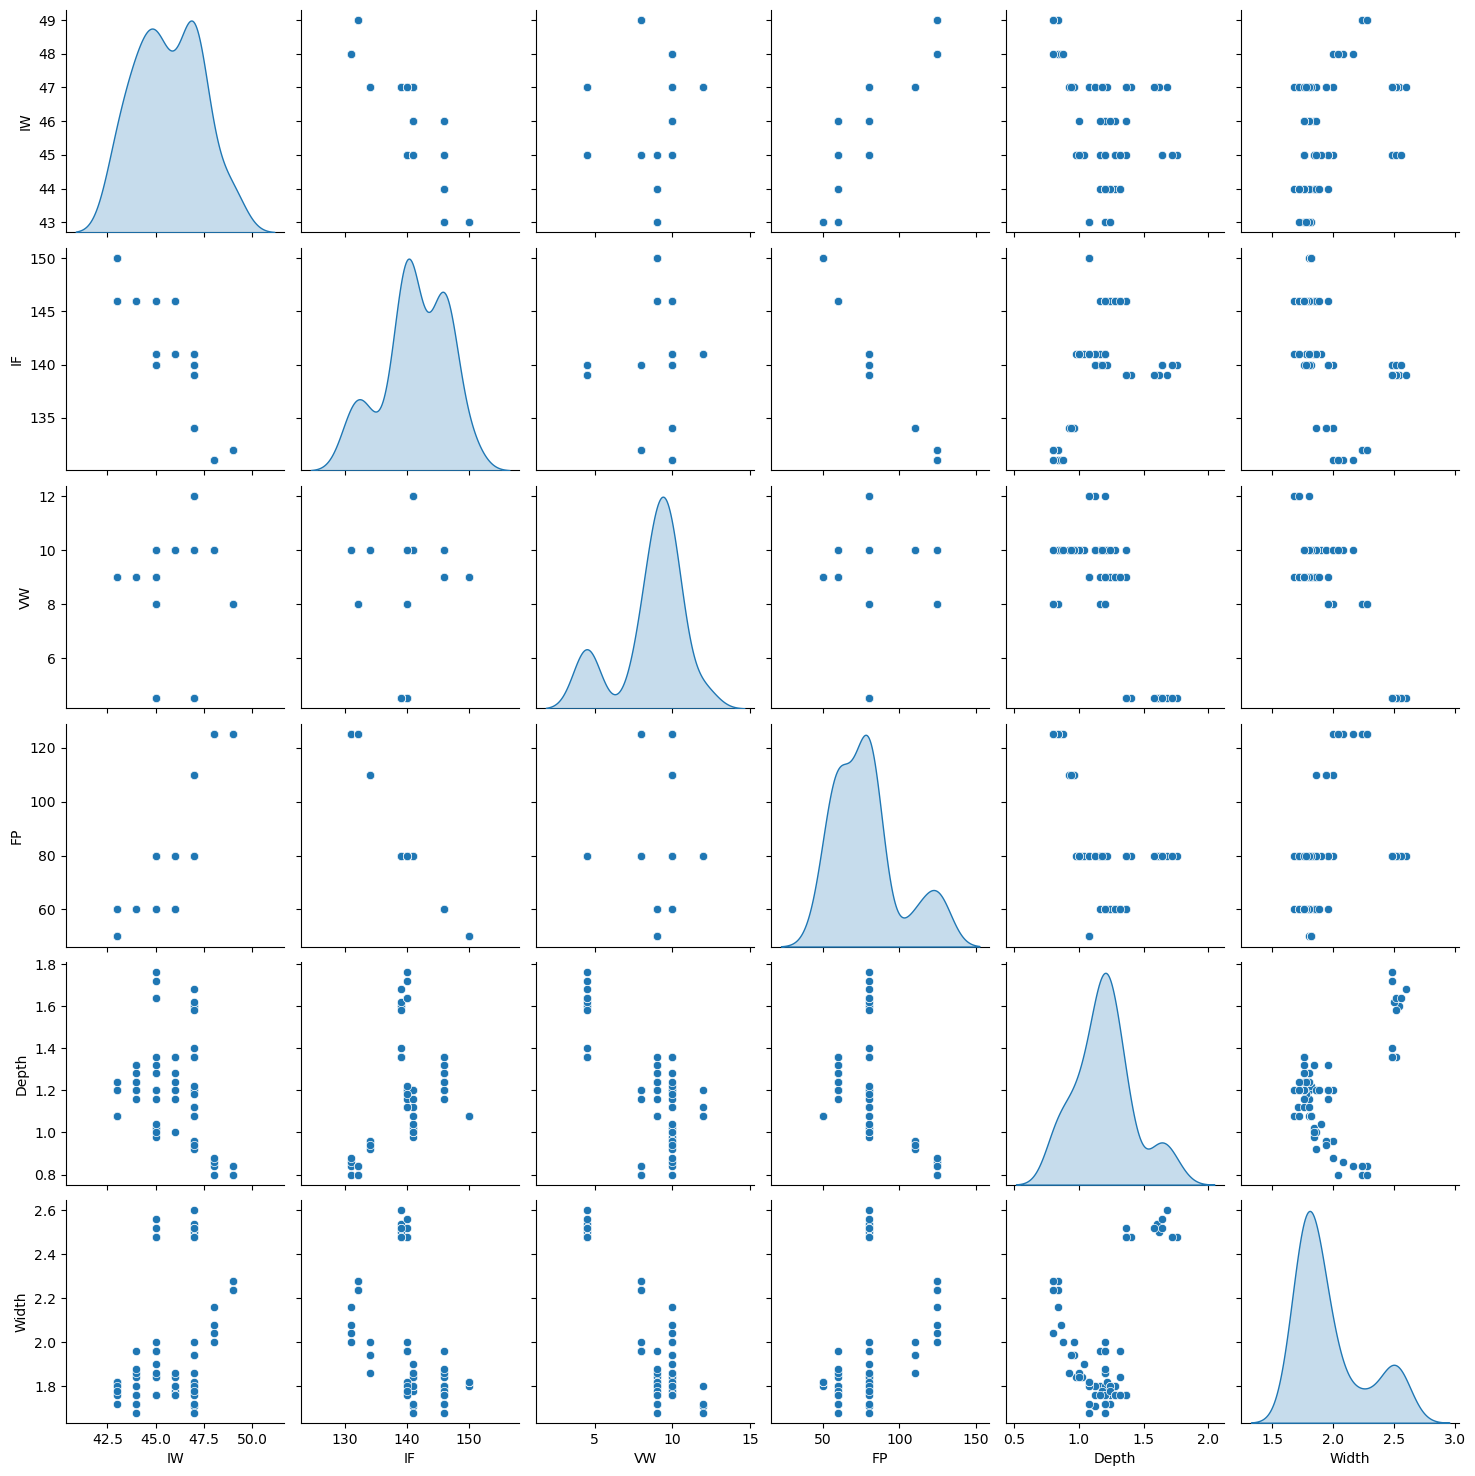

In [5]:
sns.pairplot(raw_df.astype(float), diag_kind='kde')

Судя по графикам единственный параметр имеющий возможную линейную зависимость с Width это Скорость сварки VW. Остальные параметры имееют менее выраженную зависимость, однако это может быть из за малого количества данных.

**Проверим корреляцию**

In [6]:
raw_df.corr()

,IW,IF,VW,FP,Depth,Width
IW,1.000000,-0.861073,-0.043430,0.835530,-0.289568,0.434869
IF,-0.861073,1.000000,0.115093,-0.980562,0.376084,-0.510167
VW,-0.043430,0.115093,1.000000,-0.001060,-0.671437,-0.874257
FP,0.835530,-0.980562,-0.001060,1.000000,-0.510748,0.412962
Depth,-0.289568,0.376084,-0.671437,-0.510748,1.000000,0.425391
Width,0.434869,-0.510167,-0.874257,0.412962,0.425391,1.000000


Видно явную корреляцию целевой переменной Width с атрибутом - Скорость сварки VW. Что в принципе подтверждалось и графиком выше.
Также видно некоторые взаимные зависимости между параметрами IW - IF, IW - FP, IF - FP, VW - Depth.

### Предобработка данных

Особой предобработки не требуется, единственное необходимо нормализовать данные. Однако нормализацию целесообразно выполнять в составе моделей.

В качестве предобработки рассмотрим модель LinearRegressor, для последующей оценки качества модели NN:

**Linear Regression**

In [7]:
# разделим датасет на входные переменные Х и две выходные переменные
X = raw_df.drop({'Depth', 'Width'}, axis=1)
y = raw_df[['Depth', 'Width']]

In [8]:
# разделим на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15)

# зададим модель через Pipeline
pipe_lr = Pipeline(
    [
       ('Scaler', StandardScaler()),
       ('Regression', LinearRegression())
    ]
)
# натренируем модель
pipe_lr.fit(X_train,y_train)
# посчитаем качество
print('Оценка качества: [Глубина Depth, Ширина Width]')
print('MAE: ', mean_absolute_error(y_test, pipe_lr.predict(X_test)))
print('MAE от среднего значения, %:')
print(mean_absolute_error(y_test, pipe_lr.predict(X_test))*100 / y_test.mean())

Оценка качества: [Глубина Depth, Ширина Width]
MAE:  0.061796039069472584
MAE от среднего значения, %:
Depth    5.277612
Width    3.050971
dtype: float64


В принипе точность неплохая 5% по глубине и 3% по ширине.

В качестве метки выбраны параметры:
- MAE - mean absolute error - средняя абсолютная ошибка;
- и MAE от среднего значения в % - показывает относительную ошибку от среднего значения тестовой выборки.
Эти оценки будем использовать в дальнейшем для оценки модели.



### Разработка и обучение модели NN

Подготовим данные. Разобьем на обучающую, тестовую и валидационную выборки. Учитывая, что данным мало (72 записи) оставим на тестирование 15%, а оставшиеся записи разделим в пропорции 85% - обучающая и 15% валидационная

In [9]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.15, random_state = 1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=1)

Для начала попробуем однослойную модель без нормализации без скрытых слоев. Для оценки будем использовать MAE.

Учитывая, что нам необходимо, что бы модель была не только точной, но и стабильной, будем задавать ее в ввиде функции и далее прогонять через цикл из 10 измерений с выдачей средней погрешности и ее отклонения.

In [10]:
#зададим функцию для компиляции и выдачи результатов
def MAE_of_model(model, n = 10):
    # компилируем
    model.compile(loss='mean_absolute_error', 
                            optimizer=tf.keras.optimizers.Adam(0.01))
    # обучаем
    history = model.fit(
        X_train, 
        y_train,
        validation_data=(X_val.astype(np.float32), y_val),
        verbose=0, epochs=100)
    # возвращаем MAE
    return model.evaluate(X_test, y_test, verbose=0)

# и функцию для прогона и выдачи результата
def print_MAE(model, n = 10):
    errors_l = list()
    for i in range(n):
        errors_l.append(MAE_of_model(model))
    errors = np.array(errors_l)
    print('MAE: ', errors.mean())
    print('MAE % от среднего значения: ', errors.mean() * 100 / y_test.mean())

1. Однослойная модель (просто линейная регрессия по сути):

In [11]:
# задаем модель
linear_model_1 = tf.keras.Sequential([
        layers.Dense(units=2)
        ])

print_MAE(linear_model_1)

MAE:  0.4622821420431137
MAE % от среднего значения:  Depth    43.021181
Width    24.542006
dtype: float64


Такая погрешность явно не устроит. Добавим скрытый слой с активацией relu.

In [12]:
# задаем модель
linear_model_2 = tf.keras.Sequential([
    layers.Dense(10, input_shape=(X.shape[1],), activation='relu'),
    layers.Dense(units=2)
    ])

print_MAE(linear_model_2)

MAE:  0.2568029217422009
MAE % от среднего значения:  Depth    23.898749
Width    13.633360
dtype: float64


Уже лучше, однако, это тоже мало. Добавим слой с активацией sigmoid

In [13]:
# задаем модель
linear_model_3 = tf.keras.Sequential([
    layers.Dense(10, input_shape=(X.shape[1],), activation='relu'),
    layers.Dense(10, input_shape=10, activation='sigmoid'),
    layers.Dense(units=2)
    ])

print_MAE(linear_model_3)

MAE:  0.07640095874667167
MAE % от среднего значения:  Depth    7.110072
Width    4.056035
dtype: float64


Теперь попробуем добавить слой нормализации, о котором писал выше.

In [14]:
normalizer = tf.keras.layers.Normalization(axis=1)
normalizer.adapt(np.asarray(X).astype('float32'))

nonlinear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(10, input_shape=(X.shape[1],), activation='relu'),
    layers.Dense(10, input_shape=10, activation='sigmoid'),
    layers.Dense(units=2)
    ])

print_MAE(nonlinear_model)

MAE:  0.03822498805820942
MAE % от среднего значения:  Depth    3.557317
Width    2.029319
dtype: float64


Теперь качество модели достаточно хорошее, можем переходить к сохранению модели.

### Сохранение модели

In [15]:
pickle.dump(nonlinear_model, open('Model/nl_model.pkl', 'wb'))

Проверим, правильно ли загружается и работает модель

In [17]:
model_load = pickle.load(open('Model/nl_model.pkl', 'rb'))
# проверим как работает
y_pred = model_load.predict(X_test)
# сравним с исходными данными
print('y_pred {}'.format(y_pred[:].round(2)))
print('y_test {}'.format(y_test.values.round(2)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
y_pred [[1.2  1.77]
 [1.1  1.78]
 [1.21 1.95]
 [1.29 1.76]
 [1.1  1.78]
 [0.96 1.91]
 [0.83 2.23]
 [1.1  1.78]
 [0.85 2.  ]
 [1.21 1.76]
 [1.19 1.78]]
y_test [[1.16 1.8 ]
 [1.08 1.82]
 [1.16 1.96]
 [1.36 1.76]
 [1.08 1.82]
 [0.92 1.86]
 [0.8  2.28]
 [1.08 1.82]
 [0.86 2.08]
 [1.2  1.76]
 [1.12 1.76]]


Все работает. Здесь закончили, переходим к созданию приложения в отдельной программе.

In [26]:
X_test.shape

(11, 4)

In [48]:
type(X_test.iloc[[1]])

pandas.core.frame.DataFrame

In [45]:
model_load.predict(X_test.iloc[[1]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


array([[1.103206 , 1.7785015]], dtype=float32)

In [44]:
model_load.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


array([[1.2027954 , 1.7742761 ],
       [1.103206  , 1.7785016 ],
       [1.207274  , 1.9518267 ],
       [1.2873248 , 1.7590379 ],
       [1.103206  , 1.7785016 ],
       [0.96075785, 1.9139065 ],
       [0.8319875 , 2.234968  ],
       [1.103206  , 1.7785016 ],
       [0.84924924, 1.9973727 ],
       [1.2096015 , 1.7636653 ],
       [1.1913455 , 1.7804146 ]], dtype=float32)

In [60]:
cols = X_test.iloc[[1]].columns
cols = list(cols)
cols

['IW', 'IF', 'VW', 'FP']

In [67]:
a = [43, 150, 9, 50]
an = np.array(a).T
ex = pd.DataFrame([a], columns = cols)
ex

,IW,IF,VW,FP
0,43,150,9,50


In [68]:
model_load.predict(ex)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


array([[1.103206 , 1.7785015]], dtype=float32)

In [70]:
model_load.predict(X_test.iloc[[1]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


array([[1.103206 , 1.7785015]], dtype=float32)